<a href="https://colab.research.google.com/github/RevanthBN/Iris-Pupil-Segmentation/blob/main/Iris_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mounting the Google drive and cloning the github repo!**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/Iris-Pupil-Segmentation/
!git pull

Mounted at /content/gdrive
/content/gdrive/My Drive/Iris-Pupil-Segmentation
Already up to date.


In [2]:
!pip install segmentation-models-pytorch

**Import all you want!**

In [3]:
# Global libraries
import os
from glob import glob

# Python libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import math

# Image processing
import cv2
from PIL import Image

# Pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, random_split, DataLoader
import segmentation_models_pytorch as smp

# Others
import time
cuda = torch.cuda.is_available()

**Additional global variables**



In [4]:
# Path for the training set
train_images_path = glob('training_set/images/*')
train_groundtruth_path = glob('training_set/groundtruths/*')
train_masks_path = glob('training_set/masks/*')

# Path for the test set
test_images_path = glob('testing_set/images/*')
test_groundtruth_path = glob('testing_set/groundtruths/*')
test_masks_path = glob('testing_set/masks/*')

# Image sizes for resizing
width = 256
height = 256
dim = (width, height)

**Hyperparameters to be tuned**

In [5]:
# Percentage for the train-val split
val_percent = 0.3

# Number of workers for dataloader
num_workers = 4 if cuda else 0 

# Batch size during training
batch_size = 20

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 1e-4

# Checkpoint path
checkpoint_path = "files/checkpoint.pth"


**Loading the dataset from the cloned drive folder**

In [28]:
class Iris(Dataset):
    def __init__(self, images_path, masks_path):

        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        """ Reading image """
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
        image = image/255.0 ## (256, 256, 3)
        image = np.transpose(image, (2, 0, 1))  ## (3, 256, 256)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        """ Reading mask """
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_COLOR)
        mask = cv2.resize(mask, dim, interpolation = cv2.INTER_AREA)
        mask = mask/255.0   ## (256, 256, 3)
        mask = np.transpose(mask, (2, 0, 1))  ## (3, 256, 256)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples

**Creating the datasets**

In [26]:
""" Creating the datasets """
train_dataset = Iris(train_images_path, train_masks_path)
test_set = Iris(test_images_path, test_masks_path)

**Splitting the train dataset into Training and Validation sets by a 70-30 split with a manual seed of 0**

In [27]:
n_val = int(len(train_dataset) * val_percent)
n_train = len(train_dataset) - n_val
train_set, val_set = random_split(train_dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

data_str = f"Dataset Size:\nTrain: {len(train_set)} - Validation: {len(val_set)} - Test: {len(test_set)}\n"
print(data_str)

Dataset Size:
Train: 379 - Validation: 162 - Test: 10



**Loading the dataloader for the datasets**

In [23]:
# Training data
train_loader_args = dict(shuffle=True, batch_size=batch_size, num_workers=num_workers) if cuda\
                    else dict(shuffle=True, batch_size=batch_size)
train_loader = DataLoader(train_set, **train_loader_args)

# Validation data
val_loader_args = dict(shuffle=True, batch_size=batch_size, num_workers=num_workers) if cuda\
                    else dict(shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_set, **val_loader_args)

# Testing data
test_loader_args = dict(shuffle=False, num_workers=num_workers) if cuda\
                    else dict(shuffle=False,drop_last=True)
test_loader = DataLoader(test_set, **test_loader_args)


**Dice Loss Function** 

In [10]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE


**Model definition**

In [11]:
device = torch.device("cuda" if cuda else "cpu")
model = smp.Unet('resnet34', classes=3, activation='softmax')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()
model = model.to(device)

**Training and Validation Functions**

In [15]:
def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0

    model.train()
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)
        print(y_pred.shape)
        print(y.shape)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss/len(loader)
    return epoch_loss

**Training and Evaluation of the model**

In [24]:
best_valid_loss = float("inf")

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, loss_fn, device)
    valid_loss = evaluate(model, valid_loader, loss_fn, device)

    """ Saving the model """
    if valid_loss < best_valid_loss:
        data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
        print(data_str)

        best_valid_loss = valid_loss
        torch.save(model.state_dict(), checkpoint_path)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n'
    data_str += f'\tTrain Loss: {train_loss:.3f}\n'
    data_str += f'\t Val. Loss: {valid_loss:.3f}\n'
    print(data_str)

/usr/local/lib/python3.7/dist-packages/segmentation_models_pytorch/base/modules.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


torch.Size([20, 3, 256, 256])
torch.Size([20, 1, 256, 256, 3])


NameError: ignored

(160, 224, 3)


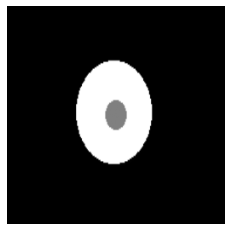

In [19]:
gg = 'training_set/masks/000008372_Ycrop_Hres_L.png'
image = cv2.imread(gg, cv2.IMREAD_COLOR)
print(image.shape)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, dim)
image = image/255.0 ## (256, 256, 3)
plt.imshow(image);
plt.axis("off");
# image = np.transpose(image, (2, 0, 1))  ## (3, 256, 256)
# image = image.astype(np.float32)
# image = torch.from_numpy(image)

In [14]:
print(model)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track